In [1]:
import grid_data
import numpy as np
import nns
import spherical_data_2
import matplotlib.pyplot as plt
from imblearn.datasets import make_imbalance
from sklearn.metrics import accuracy_score
from kotaro_method import KotaroMethod
from kotaro_rbf import KotaroMethodRBF

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline 
from sklearn.svm import SVC
import pandas as pd

from sklearn.svm import OneClassSVM
import collections

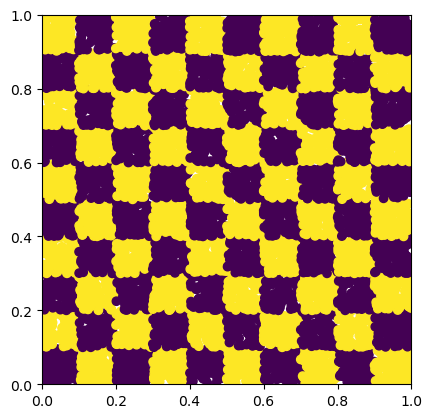

In [2]:
samples, labels = grid_data.generate_checkered_samples(grid_size=10, sample_per_region=100)

plt.scatter(samples[:, 0], samples[:, 1], c=labels)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [4]:
import pandas as pd
import collections
# パラメータの設定
num_samples = 5000000  # サンプル数
num_dimensions = 7  # N次元
num_spheres = 9     # 球の数
#sphere_radius = 0.1  # 球の半径

# 真の分布
gt_samples, gt_labels = spherical_data_2.generate_labeled_samples(num_samples, num_dimensions, num_spheres)


full_data = np.c_[gt_samples, gt_labels]

df = pd.DataFrame(full_data)
df.to_csv('./dim7_sph9/gt.csv',index=False)




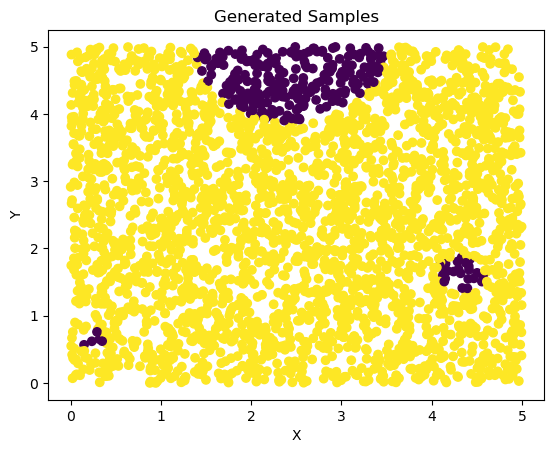

In [16]:
# パラメータの設定
num_samples = 3000  # サンプル数
num_dimensions = 2  # N次元
num_spheres = 3     # 球の数
#sphere_radius = 0.1  # 球の半径

# ラベル付きサンプルの生成
samples, labels = spherical_data_2.generate_labeled_samples(num_samples, num_dimensions, num_spheres)

# 結果の表示
def plot_samples(samples, labels):
    plt.scatter(samples[:, 0], samples[:, 1], c=labels)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Generated Samples')
    #plt.colorbar()
    plt.show()
def plot_samples3d(samples,labels):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(samples[:, 0], samples[:, 1],samples[:,2], c=labels)
    plt.show()
plot_samples(samples, labels)

In [4]:
max_distances = nns.compute_distances(samples,distance_type='max')
#print('Max Distances', max_distances)
print('min',np.min(max_distances))
print('max',np.max(max_distances))
print('mean',np.mean(max_distances))
print('variance', np.var(max_distances,ddof=1))

min 2.441416774298753
max 4.8822688262658325
mean 3.5767200843478686
variance 0.5180088537076964


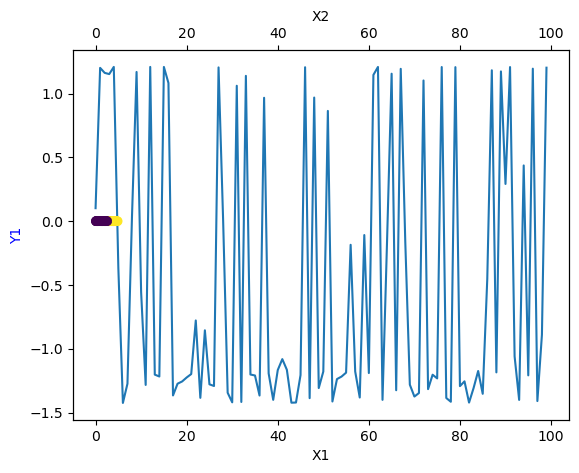

In [15]:
import numpy as np

def kde_kotaro(data, labels, bandwidths):
    """カーネル密度推定を行う関数"""
    n = len(data)
    k = lambda x: np.exp(-0.5 * (x ** 2)) / np.sqrt(2 * np.pi)  # ガウシアンカーネル

    density_estimates = np.zeros(n)

    for i in range(n):
        kernel_sum = 0.0
        weight_sum = 0.0
        for j in range(n):
            kernel = k((data[i] - data[j]) / bandwidths[j])
            kernel_sum += kernel * labels[j]
            weight_sum += kernel * bandwidths[j]
        density_estimates[i] = kernel_sum / weight_sum

    return density_estimates

# データセットの生成（正規分布に従うデータ）
#np.random.seed(42)
#data = np.random.normal(loc=0.0, scale=1.0, size=100)
#labels = np.random.choice([-1, 1], size=100)  # ラベル生成

# データ点ごとのバンド幅の設定
#bandwidths = np.abs(np.random.normal(loc=0.0, scale=0.5, size=100))
bandwidths = max_distances*0.2
# カーネル密度推定の実行
density = kde_kotaro(samples, labels, bandwidths)



fig, ax1 = plt.subplots()

# プロット1
ax1.plot(density)
ax1.set_xlabel('X1')
ax1.set_ylabel('Y1', color='b')

# 2番目のX軸を作成
ax2 = ax1.twiny()

# プロット2
ax2.scatter(samples,np.zeros_like(samples), c=labels)
ax2.set_xlabel('X2')
ax2.set_xlim(ax1.get_xlim())  # X軸の範囲を合わせる

# グラフの表示
plt.show()

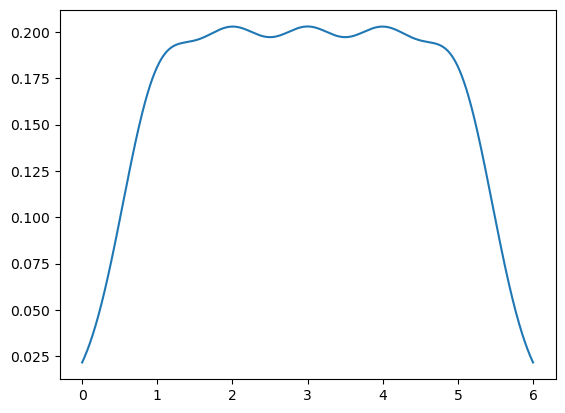

In [16]:
import numpy as np

# ガウスカーネル関数の定義
def gaussian_kernel(x, y, bandwidth):
    return np.exp(-0.5 * ((x - y) / bandwidth) ** 2) / (bandwidth * np.sqrt(2 * np.pi))

# カーネル密度推定のための関数の定義
def kde(x, data, bandwidth):
    return np.mean(gaussian_kernel(x, data, bandwidth))

# データセットの定義
data = np.array([1.0, 2.0, 3.0, 4.0, 5.0])

# バンド幅の定義
bandwidth = 0.5

# 密度関数を取り出すためのx値の範囲を定義
x_values = np.linspace(min(data) - 1, max(data) + 1, 1000)

# 各x値に対する確率密度を計算
density = [kde(x, data, bandwidth) for x in x_values]
#import matplotlib as plt
plt.plot(x_values,density)
plt.show()

In [13]:
svm = SVC()
param_svm = {
        'C': [10 ** i for i in range(-5,6)],
        'kernel': ["rbf" ],
        'decision_function_shape': ["ovo", "ovr"],
    }
        
scoring = 'accuracy'
cv = 3
gscv = GridSearchCV(svm, param_grid=param_svm,scoring=scoring, cv=cv, refit=True, )
wsvm =  SVC()
param_wsvm = {
    'C': [10 ** i for i in range(-5,6)],
    'kernel': ["rbf"],
    'class_weight':["balanced"],
    'decision_function_shape': ["ovo", "ovr"],
}
scoring = 'accuracy'
cv = 3
gscv_wsvm = GridSearchCV(wsvm, param_grid=param_wsvm,scoring=scoring, cv=cv, refit=True, )
osvm = OneClassSVM()
param_osvm = {
    'kernel': ["rbf", ],
    'nu': [i for i in np.arange(0.1,0.6,0.1)]
}
scoring = 'accuracy'
cv = 2
gscv_osvm = GridSearchCV(osvm, param_grid=param_osvm,scoring=scoring, cv=cv, refit=True, )
kotaro = KotaroMethodRBF()
param_grid = {
    'N': [i for i in range(3,7)],
    'gamma':[ i for i in range(10,15)],
    'distance_type': ['max', ]
}
gscv_kotaro = GridSearchCV(kotaro, param_grid=param_grid, scoring=scoring, cv=cv, refit=True,verbose=3)

In [15]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sphere_sampler import generate_labeled_samples  # sphere_sampler.pyから関数をインポート
from collections import Counter
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
warnings.simplefilter('ignore')
# 初期のサンプルを生成
initial_samples = 5 * np.random.rand(2000, 7)

# 球を生成し、それぞれの球の中にサンプルを生成
samples, labels, spheres = generate_labeled_samples(initial_samples, 3, 800)
# サンプルの描画
kfold = KFold(n_splits=5)
num_dimensions = 5
num_spheres = 3
svm_cv_scores = []
wsvm_cv_scores = []
osvm_cv_scores = []
kotaro_cv_scores = []

for dim in range(6, 7):
    initial_samples = 5 * np.random.rand(2000, dim)
    samples, labels, _ = generate_labeled_samples(initial_samples, num_spheres, 900)
    X_train, X_valid, y_train, y_valid = train_test_split(samples, labels, test_size=0.5)
    for i in range (0, 350, 10):
        X_imb, y_imb = make_imbalance(X_train, y_train , sampling_strategy={1:10+i, -1:700-i})
        print(Counter(y_imb))

        
        gscv.fit(X_imb, y_imb)
        best_params = gscv.best_params_
        svm_best = SVC(**best_params) 
        svm_best.fit(X_imb, y_imb)
        cv_score =  cross_val_score(svm_best, X_valid, y_valid, cv=kfold) 
        print("SVM_CV:", cv_score)  
        svm_cv_scores.append(cv_score)

        gscv_wsvm.fit(X_imb, y_imb)
        best_params = gscv_wsvm.best_params_
        wsvm_best = SVC(**best_params)
        wsvm_best.fit(X_imb, y_imb)
        cv_score =  cross_val_score(wsvm_best, X_valid, y_valid,  cv=kfold) 
        print("weightSVM_CV:", cv_score)  

        wsvm_cv_scores.append(cv_score)

        gscv_osvm.fit(X_imb, y_imb)
        best_params = gscv_osvm.best_params_
        osvm_best = OneClassSVM(**best_params)
        osvm_best.fit(X_imb, y_imb)
        cv_score =  cross_val_score(osvm_best, X_valid, y_valid, cv=kfold)  
        print("OneClassSVM_CV:", cv_score)  
 
        osvm_cv_scores.append(cv_score)

        gscv_kotaro.fit(X_imb, y_imb)
        best_params = gscv_kotaro.best_params_
        kotaro_best = KotaroMethodRBF(**best_params)
        kotaro_best.fit(X_imb, y_imb)
        cv_score =  cross_val_score(Kotaro_best, X_valid, y_valid, cv=kfold)   
        print("Kotaro_CV:", cv_score)  

        kotaro_cv_scores.append(cv_score)


Counter({-1: 700, 1: 10})


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/torainu256/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
TypeError: BaseLibSVM.fit() got an unexpected keyword argument 'C'
